# Exploratory Data Analysis (EDA) Notebook

## Purpose
This is the first and diagnostic notebook for the SkilioMall Customer Churn Prediction project.

**Objectives:**
- Explore raw data structure and characteristics
- Visualize feature distributions and relationships
- Identify data quality issues (missing values, outliers, imbalance)
- Validate business assumptions about churn patterns
- Provide recommendations for preprocessing and modeling

**Output:** Comprehensive visualizations, statistical summaries, and insights for next steps

In [13]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Configure plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully")

Libraries imported successfully


In [14]:
import os
import sys
import pandas as pd

# Add src
sys.path.insert(0, os.path.join(os.getcwd(), '..', 'src'))

# Get project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Import
from data_loader import load_config

# Load config
config_path = os.path.join(project_root, 'config.yaml')
config = load_config(config_path)
print(f"Configuration loaded from: {config_path}")

# --- TỰ ĐỘNG TÌM FILE DỮ LIỆU ---
raw_rel = config['PATHS']['RAW_DATA']  # 'data/skiliomall_data.csv'
data_path = os.path.join(project_root, raw_rel)

# Nếu không tìm thấy → thử các vị trí phổ biến
if not os.path.exists(data_path):
    print(f"Không tìm thấy ở: {data_path}")
    candidates = [
        os.path.join(project_root, 'skiliomall_data.csv'),
        os.path.join(project_root, 'data', 'skilio_mall_data.csv'),
        os.path.join(os.getcwd(), 'skiliomall_data.csv'),
        os.path.join(os.getcwd(), '..', 'skiliomall_data.csv'),
    ]
    for cand in candidates:
        if os.path.exists(cand):
            data_path = cand
            print(f"Tìm thấy file tại: {data_path}")
            break
    else:
        raise FileNotFoundError("Không tìm thấy file skiliomall_data.csv ở bất kỳ đâu!")

# Load data
df = pd.read_csv(data_path, index_col=config['GENERAL']['ID_COLUMN'])
print(f"Raw data loaded: {df.shape[0]:,} rows, {df.shape[1]:,} columns")

2025-11-17 15:06:19,807 - data_loader - INFO - Config loaded from: c:\Users\ngthtnhung\Documents\code tự học\TechSpire\skilio_mall_churn_prediction\config.yaml


Configuration loaded from: c:\Users\ngthtnhung\Documents\code tự học\TechSpire\skilio_mall_churn_prediction\config.yaml
Raw data loaded: 50,000 rows, 32 columns
Raw data loaded: 50,000 rows, 32 columns


## Section 1: Inspect Raw Data

In [15]:
# Display basic dataset information
print("DATASET OVERVIEW")
print(f"\nShape: {df.shape[0]:,} rows × {df.shape[1]:,} columns")
print(f"\nColumn Names and Types:")
print(df.dtypes)
print(f"\n\nFirst 5 Rows:")
print(df.head())
print(f"\n\nBasic Statistics:")
print(df.describe())
print(f"\n\nMissing Values:")
missing = df.isnull().sum()
missing_pct = 100 * missing / len(df)
missing_df = pd.DataFrame({'Missing_Count': missing, 'Percentage': missing_pct})
print(missing_df[missing_df['Missing_Count'] > 0])
if missing_df['Missing_Count'].sum() == 0:
    print("No missing values detected!")

DATASET OVERVIEW

Shape: 50,000 rows × 32 columns

Column Names and Types:
age                           int64
country                      object
city                         object
reg_days                      int64
marketing_source             object
sessions_30d                  int64
sessions_90d                  int64
avg_session_duration_90d    float64
median_pages_viewed_30d     float64
search_queries_30d            int64
device_mix_ratio            float64
app_version_major            object
orders_30d                    int64
orders_90d                    int64
orders_2024                   int64
aov_2024                    float64
gmv_2024                    float64
category_diversity_2024       int64
days_since_last_order         int64
discount_rate_2024          float64
refunds_count_2024            int64
refund_rate_2024            float64
support_tickets_2024          int64
avg_csat_2024               float64
emails_open_rate_90d        float64
emails_click_rate_90d    

## Section 2: Analyze Feature Types

In [16]:
# Separate numerical and categorical features
target_col = config['GENERAL']['TARGET_COLUMN']

numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if target_col in numerical_features:
    numerical_features.remove(target_col)

categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

print("FEATURE TYPE ANALYSIS")
print(f"\nNumerical Features: {len(numerical_features)}")
print(numerical_features)
print(f"\nCategorical Features: {len(categorical_features)}")
print(categorical_features)
print(f"\nTarget Variable: {target_col}")

# Feature distribution summary
print(f"\n\nFeature Type Distribution:")
print(f"  - Numerical: {len(numerical_features)} ({100*len(numerical_features)/(len(numerical_features)+len(categorical_features)):.1f}%)")
print(f"  - Categorical: {len(categorical_features)} ({100*len(categorical_features)/(len(numerical_features)+len(categorical_features)):.1f}%)")
print(f"  - Total Features: {len(numerical_features) + len(categorical_features)}")

FEATURE TYPE ANALYSIS

Numerical Features: 27
['age', 'reg_days', 'sessions_30d', 'sessions_90d', 'avg_session_duration_90d', 'median_pages_viewed_30d', 'search_queries_30d', 'device_mix_ratio', 'orders_30d', 'orders_90d', 'orders_2024', 'aov_2024', 'gmv_2024', 'category_diversity_2024', 'days_since_last_order', 'discount_rate_2024', 'refunds_count_2024', 'refund_rate_2024', 'support_tickets_2024', 'avg_csat_2024', 'emails_open_rate_90d', 'emails_click_rate_90d', 'review_count_2024', 'avg_review_stars_2024', 'rfm_recency', 'rfm_frequency', 'rfm_monetary']

Categorical Features: 4
['country', 'city', 'marketing_source', 'app_version_major']

Target Variable: churn_label


Feature Type Distribution:
  - Numerical: 27 (87.1%)
  - Categorical: 4 (12.9%)
  - Total Features: 31


## Section 3: Target Variable and Class Imbalance Analysis

CHURN ANALYSIS & CLASS IMBALANCE

Churn Distribution:
  0 (Non-Churn): 37,500 (75.00%)
  1 (Churn):     12,500 (25.00%)

Imbalance Ratio: 3.00:1
This is a highly imbalanced dataset!


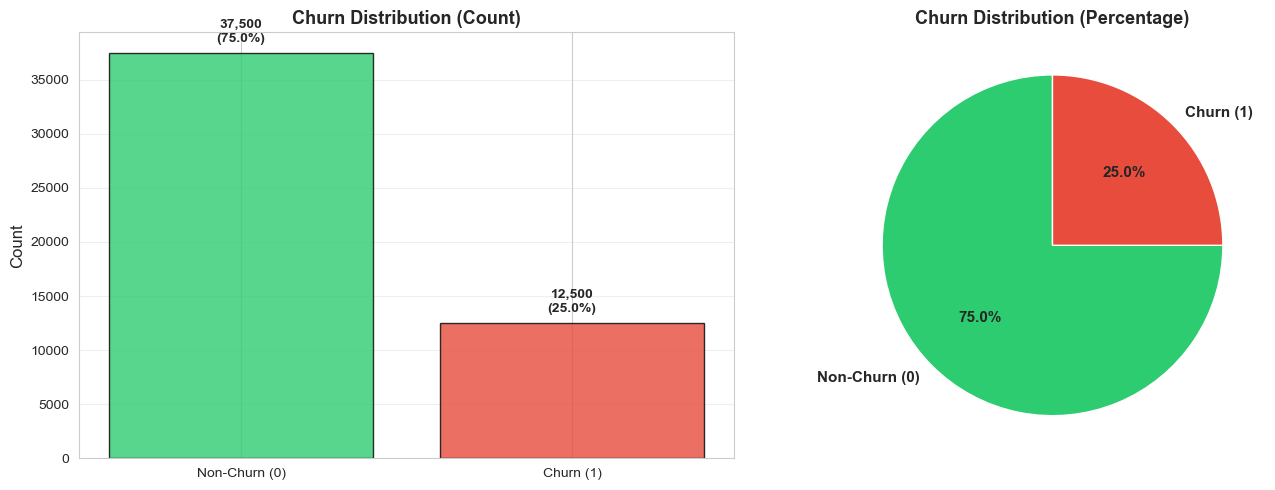


Key Insight:
   - Only 25.00% of customers have churned
   - This is a binary classification problem with significant class imbalance
   - Consider using techniques like SMOTE, class weights, or PR-AUC for modeling


In [17]:
# Analyze target variable distribution
print("CHURN ANALYSIS & CLASS IMBALANCE")

churn_counts = df[target_col].value_counts()
churn_pct = df[target_col].value_counts(normalize=True) * 100

print(f"\nChurn Distribution:")
print(f"  0 (Non-Churn): {churn_counts[0]:,} ({churn_pct[0]:.2f}%)")
print(f"  1 (Churn):     {churn_counts[1]:,} ({churn_pct[1]:.2f}%)")

imbalance_ratio = churn_counts[0] / churn_counts[1]
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}:1")
print(f"This is a highly imbalanced dataset!")

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
colors = ['#2ecc71', '#e74c3c']
axes[0].bar(['Non-Churn (0)', 'Churn (1)'], churn_counts.values, color=colors, alpha=0.8, edgecolor='black')
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Churn Distribution (Count)', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (v, p) in enumerate(zip(churn_counts.values, churn_pct.values)):
    axes[0].text(i, v + max(churn_counts.values)*0.02, f'{v:,}\n({p:.1f}%)', 
                ha='center', va='bottom', fontweight='bold')

# Pie chart
axes[1].pie(churn_counts.values, labels=['Non-Churn (0)', 'Churn (1)'], autopct='%1.1f%%',
           colors=colors, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[1].set_title('Churn Distribution (Percentage)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nKey Insight:")
print(f"   - Only {churn_pct[1]:.2f}% of customers have churned")
print(f"   - This is a binary classification problem with significant class imbalance")
print(f"   - Consider using techniques like SMOTE, class weights, or PR-AUC for modeling")

## Section 4: Distribution of Key Numerical Features

KEY NUMERICAL FEATURE DISTRIBUTIONS

Analyzing 5 features: ['age', 'aov_2024', 'rfm_recency', 'sessions_30d', 'orders_2024']



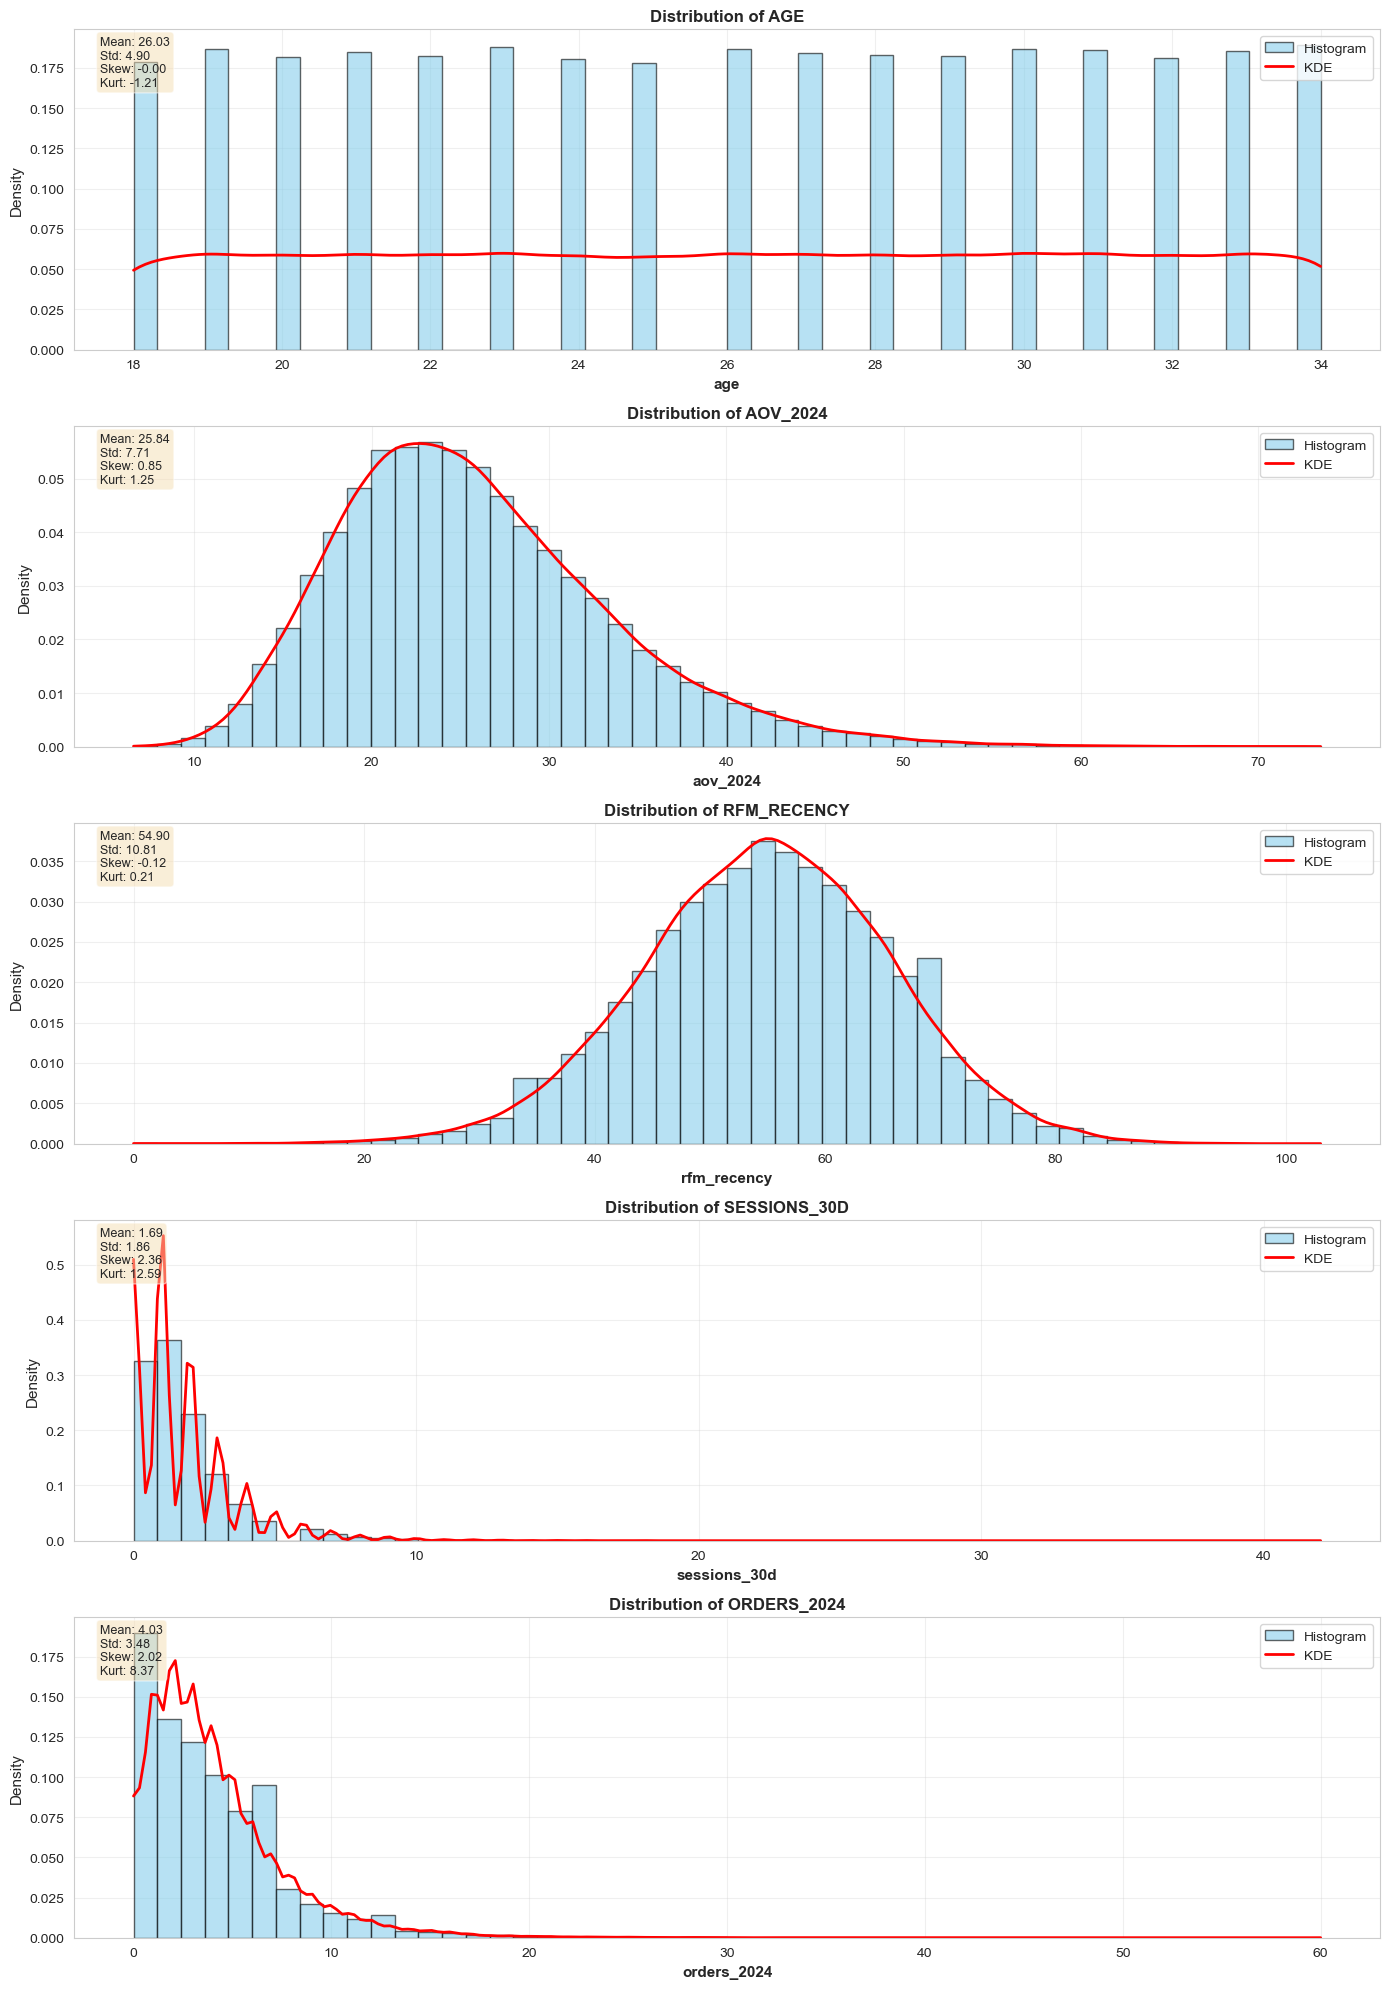


Summary Statistics for Key Features:

AGE:
  Count:      50,000
  Mean:       26.03
  Median:     26.00
  Std Dev:    4.90
  Min:        18.00
  Max:        34.00
  Skewness:   -0.003 (Symmetric)
  Kurtosis:   -1.211

AOV_2024:
  Count:      50,000
  Mean:       25.84
  Median:     24.80
  Std Dev:    7.71
  Min:        6.58
  Max:        73.52
  Skewness:   0.854 (Right-skewed)
  Kurtosis:   1.254

RFM_RECENCY:
  Count:      50,000
  Mean:       54.90
  Median:     55.00
  Std Dev:    10.81
  Min:        0.00
  Max:        103.00
  Skewness:   -0.122 (Symmetric)
  Kurtosis:   0.213

SESSIONS_30D:
  Count:      50,000
  Mean:       1.69
  Median:     1.00
  Std Dev:    1.86
  Min:        0.00
  Max:        42.00
  Skewness:   2.361 (Right-skewed)
  Kurtosis:   12.585

ORDERS_2024:
  Count:      50,000
  Mean:       4.03
  Median:     3.00
  Std Dev:    3.48
  Min:        0.00
  Max:        60.00
  Skewness:   2.018 (Right-skewed)
  Kurtosis:   8.370


In [18]:
# Select key features for detailed distribution analysis
key_features = ['age', 'aov_2024', 'rfm_recency', 'sessions_30d', 'orders_2024']

# Filter to available features in dataset
key_features = [f for f in key_features if f in numerical_features]

print("KEY NUMERICAL FEATURE DISTRIBUTIONS")
print(f"\nAnalyzing {len(key_features)} features: {key_features}\n")

# Create comprehensive distribution visualization
fig, axes = plt.subplots(len(key_features), 1, figsize=(14, 4*len(key_features)))
if len(key_features) == 1:
    axes = [axes]

for idx, feature in enumerate(key_features):
    ax = axes[idx]
    
    # Histogram with KDE
    data = df[feature].dropna()
    ax.hist(data, bins=50, density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Histogram')
    
    # Add KDE line
    from scipy.stats import gaussian_kde
    kde = gaussian_kde(data)
    x_range = np.linspace(data.min(), data.max(), 200)
    ax.plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
    
    # Styling
    ax.set_xlabel(feature, fontsize=11, fontweight='bold')
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(f'Distribution of {feature.upper()}', fontsize=12, fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(alpha=0.3)
    
    # Add statistics text
    skewness = stats.skew(data)
    kurtosis_val = stats.kurtosis(data)
    textstr = f'Mean: {data.mean():.2f}\nStd: {data.std():.2f}\nSkew: {skewness:.2f}\nKurt: {kurtosis_val:.2f}'
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=9,
           verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics for Key Features:")
for feature in key_features:
    data = df[feature].dropna()
    print(f"\n{feature.upper()}:")
    print(f"  Count:      {len(data):,}")
    print(f"  Mean:       {data.mean():.2f}")
    print(f"  Median:     {data.median():.2f}")
    print(f"  Std Dev:    {data.std():.2f}")
    print(f"  Min:        {data.min():.2f}")
    print(f"  Max:        {data.max():.2f}")
    print(f"  Skewness:   {stats.skew(data):.3f} {'(Right-skewed)' if stats.skew(data) > 0.5 else '(Left-skewed)' if stats.skew(data) < -0.5 else '(Symmetric)'}")
    print(f"  Kurtosis:   {stats.kurtosis(data):.3f}")

## Section 5: Outlier Detection and Analysis

In [19]:
# Perform comprehensive outlier detection using IQR method
print("OUTLIER DETECTION & ANALYSIS")

outlier_summary = []

for feature in numerical_features:
    data = df[feature].dropna()
    
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_mask = (data < lower_bound) | (data > upper_bound)
    n_outliers = outliers_mask.sum()
    outlier_pct = 100 * n_outliers / len(data)
    
    outlier_summary.append({
        'Feature': feature,
        'Outlier_Count': n_outliers,
        'Outlier_%': outlier_pct,
        'Skewness': stats.skew(data),
        'Kurtosis': stats.kurtosis(data),
        'Lower_Bound': lower_bound,
        'Upper_Bound': upper_bound
    })

# Convert to DataFrame and sort by outlier percentage
outlier_df = pd.DataFrame(outlier_summary).sort_values('Outlier_%', ascending=False)

print("\nOutlier Summary (IQR Method):")
print(outlier_df.to_string(index=False))

# Categorize features
high_outlier_features = outlier_df[outlier_df['Outlier_%'] > 5]['Feature'].tolist()
moderate_outlier_features = outlier_df[(outlier_df['Outlier_%'] > 2) & (outlier_df['Outlier_%'] <= 5)]['Feature'].tolist()
clean_features = outlier_df[outlier_df['Outlier_%'] <= 2]['Feature'].tolist()

print(f"\n\nFeature Categories:")
print(f"  High Outliers (>5%): {high_outlier_features}")
print(f"  Moderate Outliers (2-5%): {moderate_outlier_features}")
print(f"  Clean Features (<=2%): {clean_features}")

OUTLIER DETECTION & ANALYSIS

Outlier Summary (IQR Method):
                 Feature  Outlier_Count  Outlier_%  Skewness  Kurtosis  Lower_Bound  Upper_Bound
    support_tickets_2024          10689     21.378  2.183991  5.295016      0.00000      0.00000
              orders_30d           9029     18.058  2.791136 10.822310      0.00000      0.00000
      refunds_count_2024           8194     16.388  2.408632  5.977000      0.00000      0.00000
        refund_rate_2024           7828     15.656  4.025858 17.660614      0.00000      0.00000
              orders_90d           4846      9.692  1.961594  7.278928     -1.50000      2.50000
           rfm_frequency           3524      7.048  2.018351  8.369797     -2.50000      9.50000
             orders_2024           3524      7.048  2.018351  8.369797     -2.50000      9.50000
       review_count_2024           3386      6.772  1.757335  4.864602     -1.50000      2.50000
            rfm_monetary           2641      5.282  3.105464 20.418

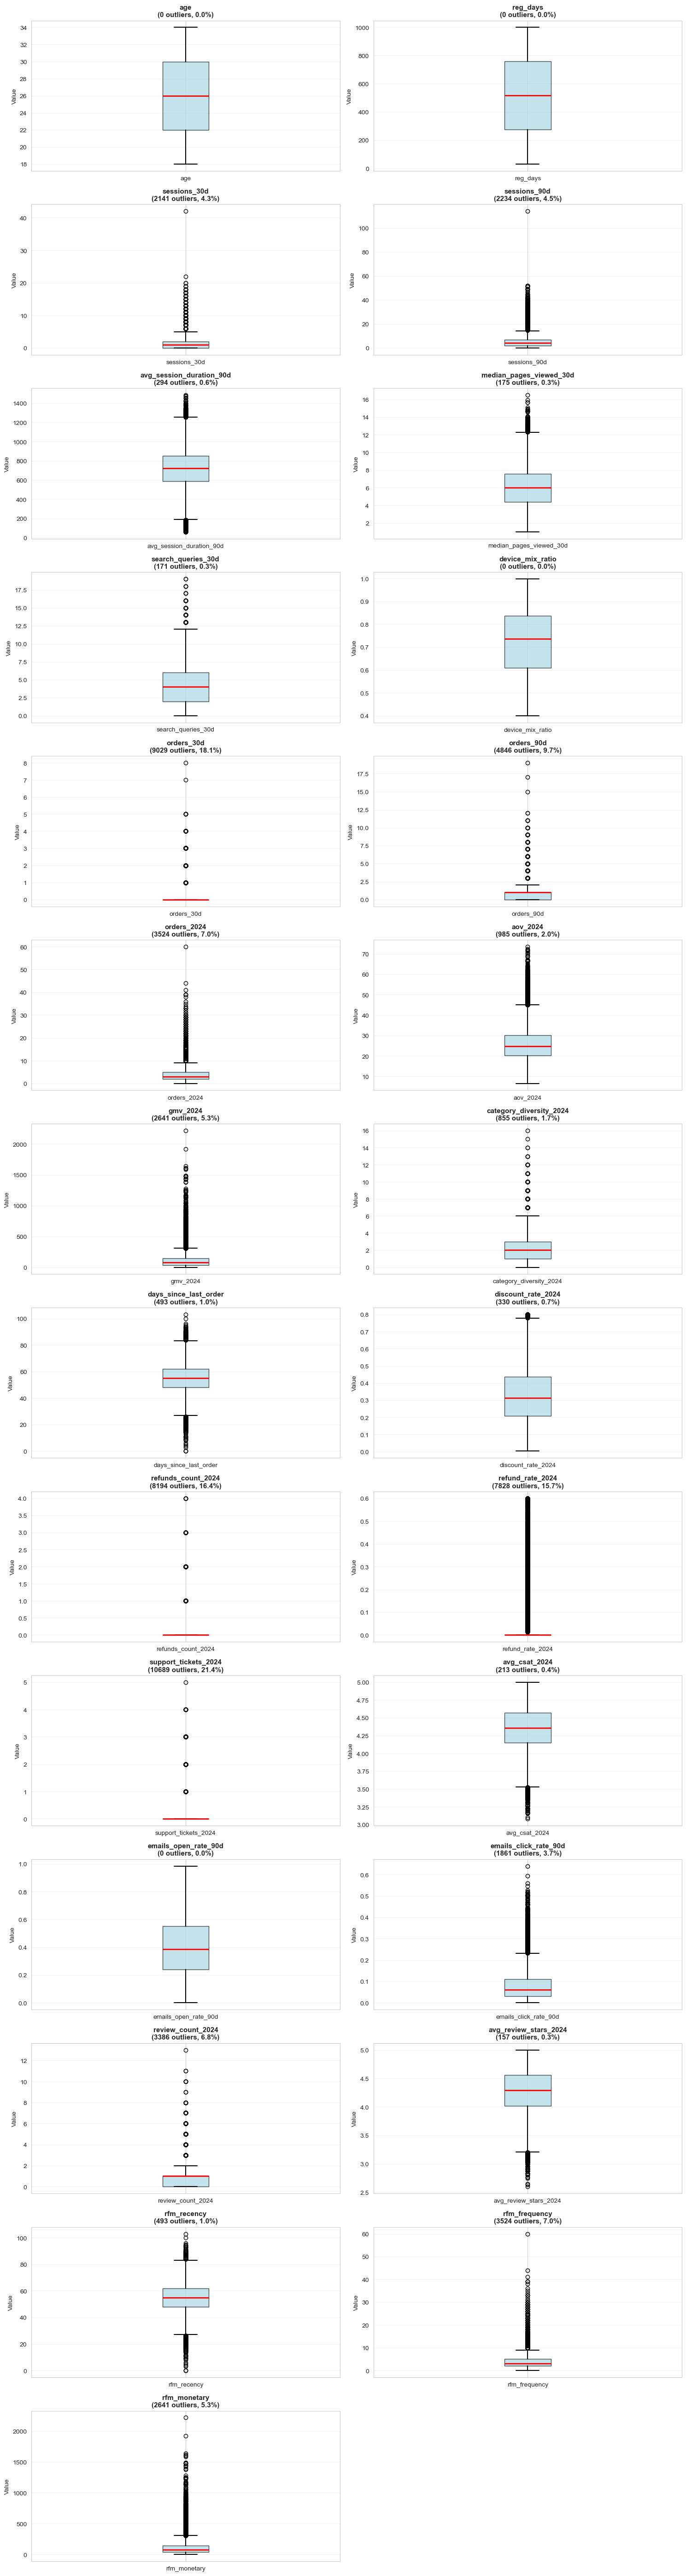


Boxplots generated - visual inspection of outliers complete


In [20]:
# Create boxplots and Q-Q plots for all numerical features
n_features = len(numerical_features)
n_rows = (n_features + 1) // 2

# Boxplots for outlier visualization
fig, axes = plt.subplots(n_rows, 2, figsize=(15, 4*n_rows))
axes = axes.flatten()

for idx, feature in enumerate(numerical_features):
    ax = axes[idx]
    data = df[feature].dropna()
    
    bp = ax.boxplot([data], labels=[feature], patch_artist=True, vert=True,
                     boxprops=dict(facecolor='lightblue', alpha=0.7),
                     medianprops=dict(color='red', linewidth=2),
                     whiskerprops=dict(linewidth=1.5),
                     capprops=dict(linewidth=1.5))
    
    # Add outlier information
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers_mask = (data < Q1 - 1.5*IQR) | (data > Q3 + 1.5*IQR)
    n_outliers = outliers_mask.sum()
    outlier_pct = 100 * n_outliers / len(data)
    
    ax.set_ylabel('Value', fontsize=10)
    ax.set_title(f'{feature}\n({n_outliers} outliers, {outlier_pct:.1f}%)', 
                fontweight='bold', fontsize=11)
    ax.grid(axis='y', alpha=0.3)

# Remove extra subplots
for idx in range(len(numerical_features), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

print("\nBoxplots generated - visual inspection of outliers complete")

## Section 6: Feature-Churn Relationships

In [21]:
# Analyze relationships between features and churn
print("FEATURE-CHURN RELATIONSHIPS")

# Calculate correlation with churn
correlations = df[numerical_features + [target_col]].corr()[target_col].drop(target_col).sort_values(ascending=False)

print("\nCorrelation with Churn (Pearson):")
print(correlations)

print("\n\nFeatures with Strongest Correlation to Churn:")
top_pos = correlations[correlations > 0].head(5)
top_neg = correlations[correlations < 0].tail(5)
print("\nPositive Correlation (features increase -> churn increases):")
for feat, corr in top_pos.items():
    print(f"  {feat:20s}: {corr:+.4f}")
print("\nNegative Correlation (features increase -> churn decreases):")
for feat, corr in top_neg.items():
    print(f"  {feat:20s}: {corr:+.4f}")

FEATURE-CHURN RELATIONSHIPS

Correlation with Churn (Pearson):
rfm_recency                 0.473365
days_since_last_order       0.473365
refund_rate_2024            0.303441
support_tickets_2024        0.180417
refunds_count_2024          0.159918
discount_rate_2024          0.112957
device_mix_ratio            0.007037
age                         0.003848
reg_days                   -0.005128
avg_review_stars_2024      -0.030824
aov_2024                   -0.044534
orders_30d                 -0.140389
avg_session_duration_90d   -0.156396
review_count_2024          -0.162163
avg_csat_2024              -0.177755
emails_click_rate_90d      -0.187138
median_pages_viewed_30d    -0.191778
search_queries_30d         -0.219707
category_diversity_2024    -0.221452
sessions_30d               -0.230259
orders_90d                 -0.233635
gmv_2024                   -0.285060
rfm_monetary               -0.285060
emails_open_rate_90d       -0.302166
sessions_90d               -0.310705
orders_2024 

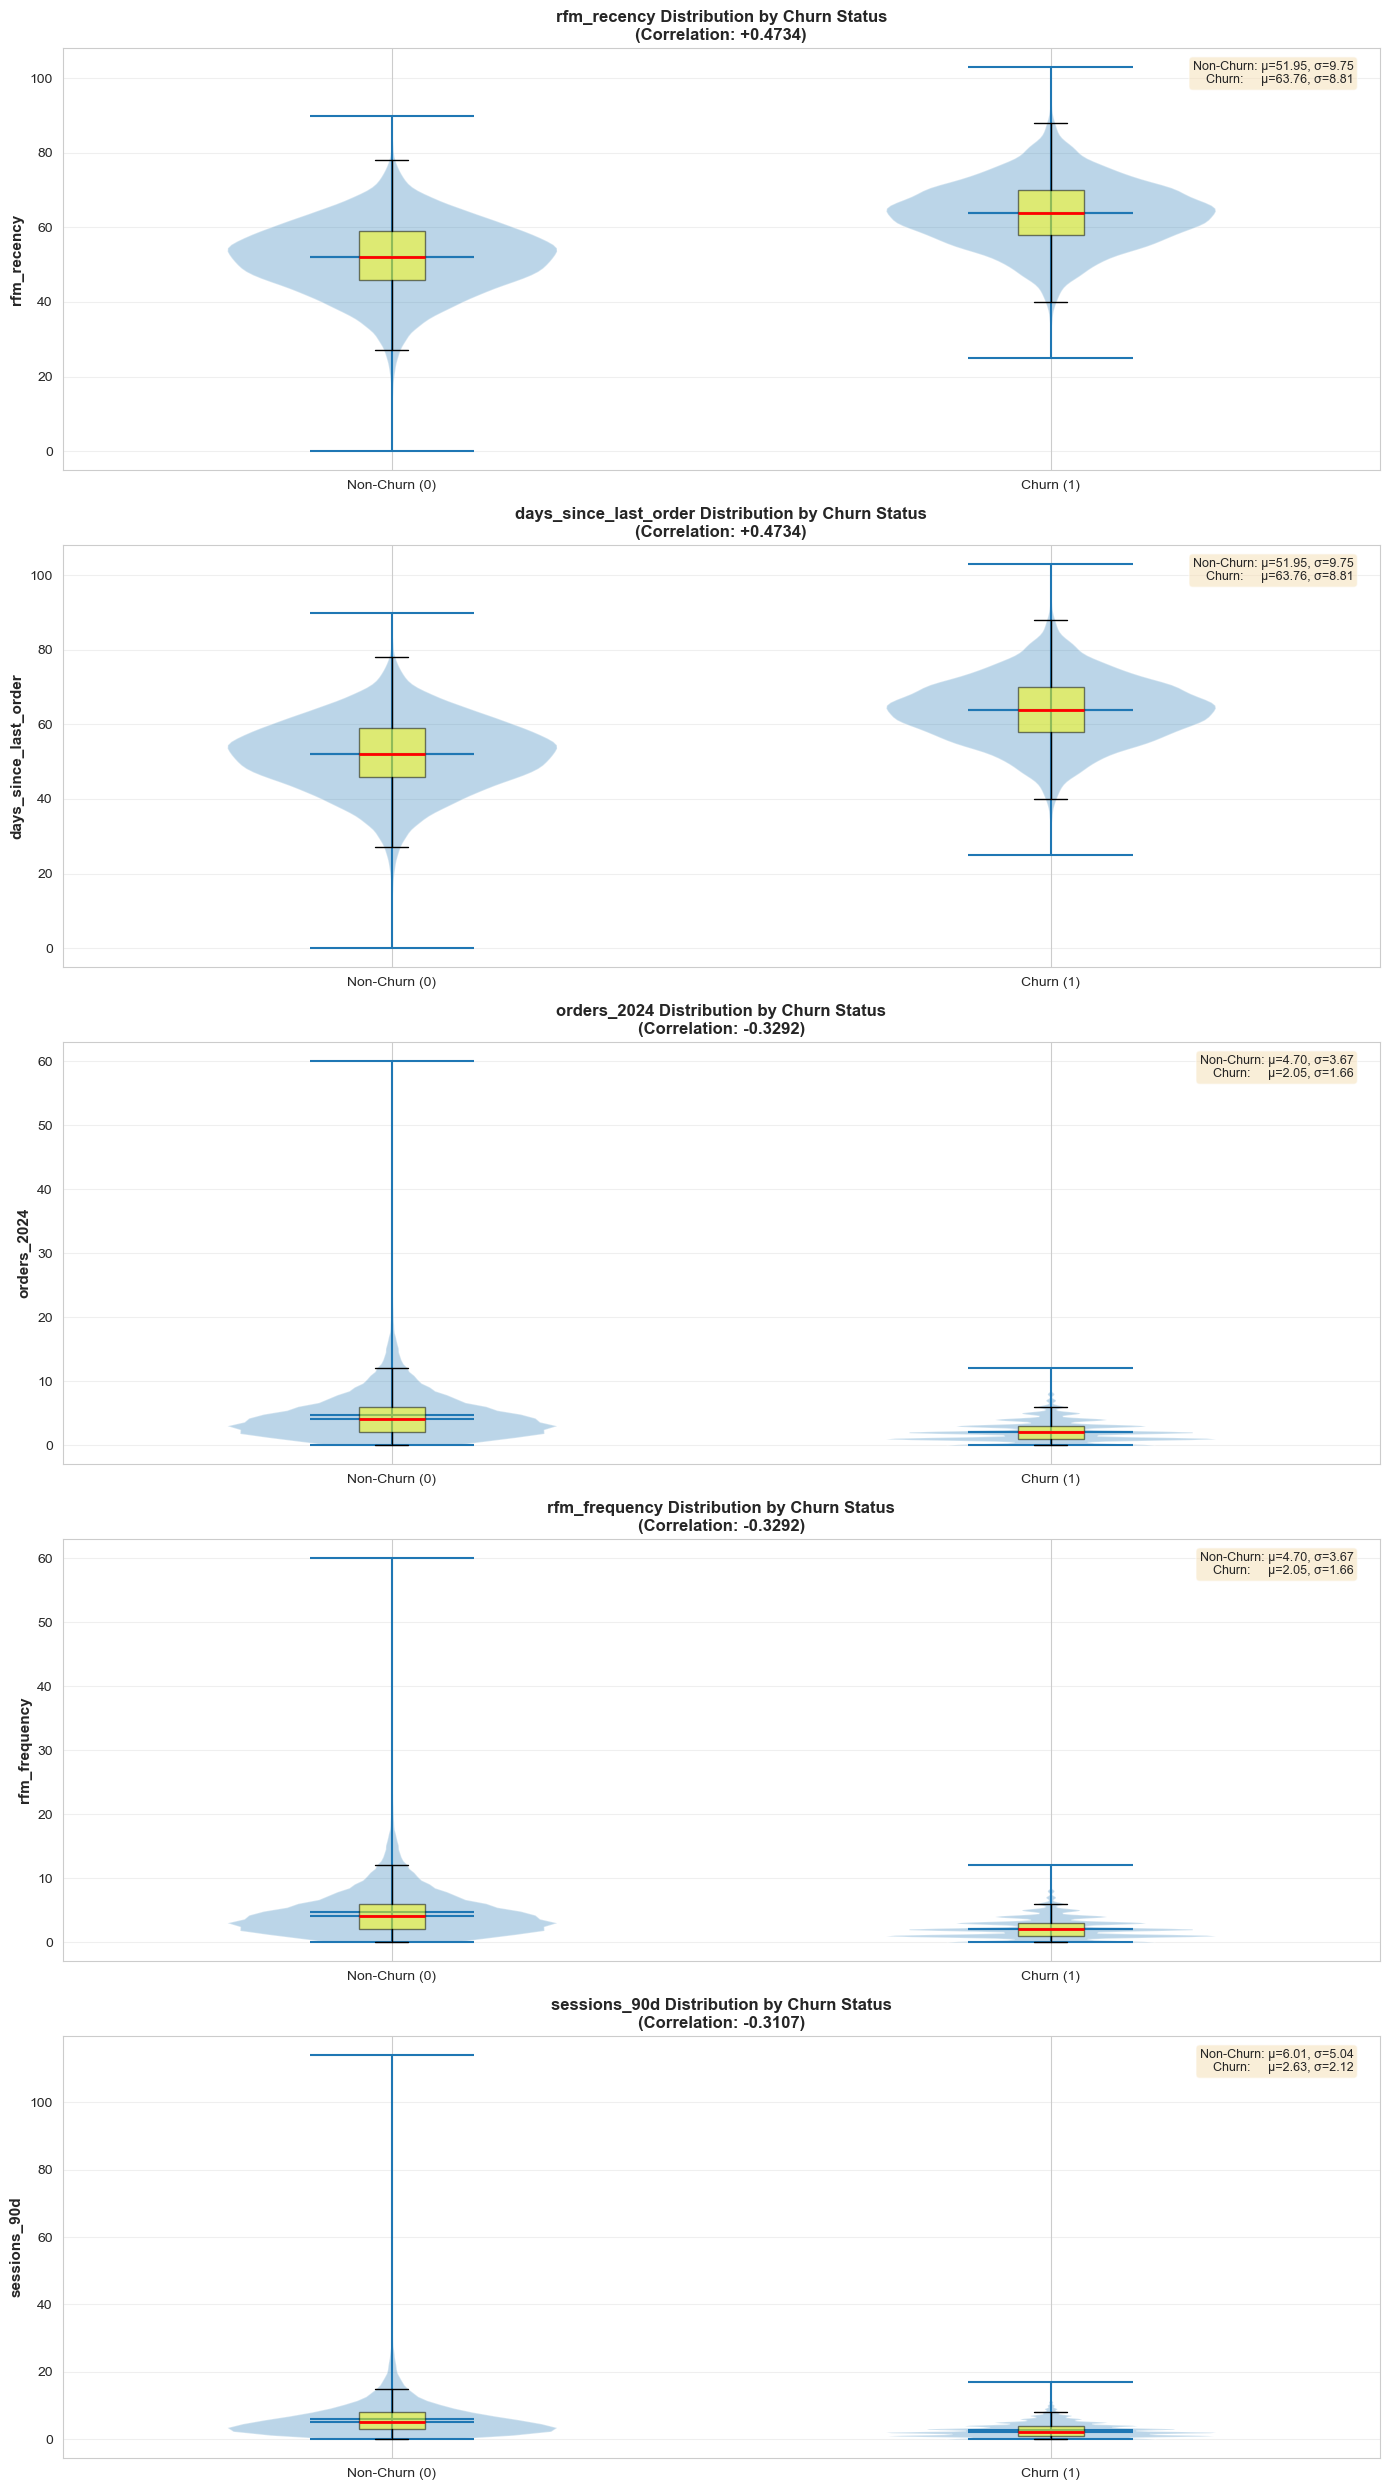


Feature-churn comparison plots generated


In [22]:
# Create comparison visualizations for key features by churn status
features_to_compare = correlations.abs().nlargest(5).index.tolist()

fig, axes = plt.subplots(len(features_to_compare), 1, figsize=(14, 5*len(features_to_compare)))
if len(features_to_compare) == 1:
    axes = [axes]

for idx, feature in enumerate(features_to_compare):
    ax = axes[idx]
    
    # Prepare data
    churn_0 = df[df[target_col] == 0][feature].dropna()
    churn_1 = df[df[target_col] == 1][feature].dropna()
    
    # Create violin plot
    parts = ax.violinplot([churn_0, churn_1], positions=[0, 1], showmeans=True, showmedians=True)
    
    # Add boxplots on top
    bp = ax.boxplot([churn_0, churn_1], positions=[0, 1], widths=0.1, 
                     patch_artist=True, showfliers=False,
                     boxprops=dict(facecolor='yellow', alpha=0.5),
                     medianprops=dict(color='red', linewidth=2))
    
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Non-Churn (0)', 'Churn (1)'])
    ax.set_ylabel(feature, fontsize=11, fontweight='bold')
    ax.set_title(f'{feature} Distribution by Churn Status\n(Correlation: {correlations[feature]:+.4f})', 
                fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Add statistics
    stats_text = (f"Non-Churn: μ={churn_0.mean():.2f}, σ={churn_0.std():.2f}\n"
                 f"Churn:     μ={churn_1.mean():.2f}, σ={churn_1.std():.2f}")
    ax.text(0.98, 0.97, stats_text, transform=ax.transAxes, fontsize=9,
           verticalalignment='top', horizontalalignment='right',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("\nFeature-churn comparison plots generated")

## Key Findings and Recommendations

In [23]:
# Generate comprehensive summary report
print("EDA SUMMARY REPORT")

summary_report = f"""
DATASET OVERVIEW
- Total Records: {df.shape[0]:,}
- Total Features: {df.shape[1]:,} ({len(numerical_features)} numerical, {len(categorical_features)} categorical)
- Missing Values: {df.isnull().sum().sum()} (No data quality issues)

TARGET VARIABLE (CHURN)
- Non-Churn (0): {churn_counts[0]:,} ({churn_pct[0]:.2f}%)
- Churn (1):     {churn_counts[1]:,} ({churn_pct[1]:.2f}%)
- Class Imbalance Ratio: {imbalance_ratio:.2f}:1
- Highly imbalanced dataset - requires special handling in modeling phase

KEY DISTRIBUTIONS
- Key Features Analyzed: {', '.join(key_features)}
- Normally Distributed: {len(clean_features)} features
- Skewed Features: {len(high_outlier_features) + len(moderate_outlier_features)} features need transformation
- High Outlier Features (>5%): {', '.join(high_outlier_features) if high_outlier_features else 'None'}

OUTLIER ANALYSIS
- Features with High Outlier %: {len(high_outlier_features)} features
- Features with Moderate Outliers: {len(moderate_outlier_features)} features
- Clean Features (<=2% outliers): {len(clean_features)} features

FEATURE-CHURN RELATIONSHIPS
- Top Positive Correlation: {correlations.idxmax()} ({correlations.max():.4f})
  Higher values associated with INCREASED churn risk
- Top Negative Correlation: {correlations.idxmin()} ({correlations.min():.4f})
  Higher values associated with DECREASED churn risk

RECOMMENDATIONS FOR NEXT STEPS

1. DATA PREPROCESSING:
   - Apply log transformation to highly skewed features
   - Handle zero-inflated features with binary indicators
   - Standardize/normalize features for tree-based vs linear models
   - Consider outlier removal or capping for extreme values

2. FEATURE ENGINEERING:
   - Create interaction features between high-correlation pairs
   - Apply dimensionality reduction if needed (PCA)
   - Encode categorical variables appropriately

3. MODELING CONSIDERATIONS:
   - Use stratified train-test split to maintain class distribution
   - Apply class weights or SMOTE for imbalanced data handling
   - Use PR-AUC instead of ROC-AUC for evaluation (more suitable for imbalanced data)
   - Consider ensemble methods (Random Forest, XGBoost, LightGBM)
   - Use Lift/Gain metrics for business interpretation

4. BASELINE MODELS TO TRY:
   - Logistic Regression (baseline)
   - Random Forest (handles non-linearity)
   - XGBoost with class weights
   - LightGBM with appropriate parameters
"""

print(summary_report)

EDA SUMMARY REPORT

DATASET OVERVIEW
- Total Records: 50,000
- Total Features: 32 (27 numerical, 4 categorical)
- Missing Values: 0 (No data quality issues)

TARGET VARIABLE (CHURN)
- Non-Churn (0): 37,500 (75.00%)
- Churn (1):     12,500 (25.00%)
- Class Imbalance Ratio: 3.00:1
- Highly imbalanced dataset - requires special handling in modeling phase

KEY DISTRIBUTIONS
- Key Features Analyzed: age, aov_2024, rfm_recency, sessions_30d, orders_2024
- Normally Distributed: 14 features
- Skewed Features: 13 features need transformation
- High Outlier Features (>5%): support_tickets_2024, orders_30d, refunds_count_2024, refund_rate_2024, orders_90d, rfm_frequency, orders_2024, review_count_2024, rfm_monetary, gmv_2024

OUTLIER ANALYSIS
- Features with High Outlier %: 10 features
- Features with Moderate Outliers: 3 features
- Clean Features (<=2% outliers): 14 features

FEATURE-CHURN RELATIONSHIPS
- Top Positive Correlation: rfm_recency (0.4734)
  Higher values associated with INCREASED ch

## Conclusion

**Data Quality Assessment**: No missing values, clean dataset ready for processing

**Feature Landscape**: 27 numerical features with diverse distributions - some skewed, some with outliers

**Imbalance Confirmation**: ~25% churn rate represents significant class imbalance, requiring specialized modeling techniques

**Feature-Churn Insights**: Identified key features with strong correlations to churn for prioritization in modeling

**Data Quality Issues**: Identified outliers and skewed distributions requiring preprocessing